In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reproduced paper code

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Hyperparameter initialisation

In [4]:
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Custom transformation class
class FacePreprocessing:
    def __init__(self, size=(224, 224)):
        self.size = size
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.sift = cv2.SIFT_create()

    def detect_face(self, image):
        """Detect face using Viola-Jones (Haar cascade)."""
        image = np.array(image)
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)
        if len(faces) == 0:
            return None  # No face detected
        return faces[0]  # Return first detected face (x, y, w, h)

    def crop_face(self, image, face_coords):
        """Crop the face from the image."""
        x, y, w, h = face_coords
        return image[y:y+h, x:x+w]

    def resize_image(self, image):
        """Resize image to the standard size."""
        return cv2.resize(image, self.size)

    def normalize_image(self, image):
        """Normalize pixel values to [0,1] range."""
        return image / 255.0

    def gaussian_blur(self, image):
        """Apply Gaussian smoothing."""
        return cv2.GaussianBlur(image, (5, 5), 0)

    def sift_align_face(self, image):
        """Align face using SIFT keypoints matching."""
        if len(image.shape) == 2:
            gray = image
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        center_ref = (w // 2, h // 2)  # Assume nose is the center

        keypoints, descriptors = self.sift.detectAndCompute(gray, None)
        if len(keypoints) == 0:
            return image  # No keypoints detected, return original

        # Find the keypoint closest to the center (assume it's the nose region)
        center_kp = min(keypoints, key=lambda kp: (kp.pt[0] - center_ref[0])**2 + (kp.pt[1] - center_ref[1])**2)
        dx = center_ref[0] - center_kp.pt[0]
        dy = center_ref[1] - center_kp.pt[1]

        # Apply translation to center the keypoint
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        aligned = cv2.warpAffine(image, M, (w, h))
        return aligned

    def __call__(self, image):
        """Full preprocessing pipeline."""
        face_coords = self.detect_face(image)
        if face_coords is not None:
            image_np = np.array(image)
            face = self.crop_face(image_np, face_coords)
        else:
            face = np.array(image)  # Fallback if no face detected

        aligned_face = self.sift_align_face(face)
        resized_face = self.resize_image(aligned_face)
        blurred_face = self.gaussian_blur(resized_face)
        normalized_face = self.normalize_image(blurred_face)

        # Convert to PIL Image and return as Tensor
        return Image.fromarray((normalized_face * 255).astype(np.uint8))

# Apply custom transformations in the DataLoader
transform = transforms.Compose([
    FacePreprocessing(size=(48, 48)),  # Resize face images to 48x48 as in FER2013
    transforms.ToTensor()
])

In [5]:
train= datasets.FER2013(root="/content/drive/MyDrive", split='train',transform=transform)
test= datasets.FER2013(root="/content/drive/MyDrive", split='test', transform=transform)

In [6]:
from torch.utils.data import DataLoader
train_dl=DataLoader(train,batch_size=256,num_workers=2,shuffle=True,pin_memory=True)
test_dl=DataLoader(test,batch_size=256,shuffle=True,num_workers=2,pin_memory=True)

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  else:
    return data.to(device,non_blocking=True)

class DeviceDataloader():
  def __init__(self,device,dl):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch,self.device)

  def __len__(self):
    return len(self.dl)

device=get_default_device()
train_dl=DeviceDataloader(device,train_dl)
test_dl=DeviceDataloader(device,test_dl)
device

device(type='cuda')

## Modeling

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 12 * 12, 256)  # 224 -> 112 -> 56 after pooling twice
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 7)  # Assuming 7 emotion classes (Happy, Sad, etc.)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))  # THIS is the feature vector (fc1 output)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = EmotionCNN()  # Assuming 7 emotions
# model.load_state_dict(torch.load(f"/content/drive/MyDrive/fer2013/reproduced_cnn_10.pt"))
model.to(device)
opt=torch.optim.Adam(model.parameters(),lr=1e-3)
from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.CrossEntropyLoss()

In [ ]:
scheduler = OneCycleLR(opt, max_lr=1e-3, epochs=50, steps_per_epoch=len(train_dl))
train_epoch_losses=[]
test_epoch_losses=[]

In [ ]:
for epoch in range(50):  # Set the number of epochs
    model.train()
    train_epoch_loss = 0
    test_epoch_loss=0
    for images, label in train_dl:
        # Forward pass
        outputs = model(images)
        loss=criterion(outputs, label)
        train_epoch_loss += loss.item()

        # Backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
    train_epoch_losses.append(train_epoch_loss/len(train_dl))
    print(f"Epoch {epoch+1}, Train Loss: {train_epoch_loss/len(train_dl)}")

    for images, label in test_dl:
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, label)
            test_epoch_loss += loss.item()
    test_epoch_losses.append(test_epoch_loss/len(test_dl))
    print(f"Test Loss: {test_epoch_loss/len(test_dl)}")
    torch.save(model.state_dict(),f"/content/drive/MyDrive/fer2013/reproduced_cnn_{epoch+1}.pt")

Epoch 1, Train Loss: 1.8318239461004207
Test Loss: 1.7860729982113015
Epoch 2, Train Loss: 1.7859323288487121
Test Loss: 1.760938179904017
Epoch 3, Train Loss: 1.7698932886123657
Test Loss: 1.7474659434680282
Epoch 4, Train Loss: 1.7450596051933491
Test Loss: 1.7222930439587296
Epoch 5, Train Loss: 1.7215562942808709
Test Loss: 1.6991473313035637
Epoch 6, Train Loss: 1.6934462121102662
Test Loss: 1.6677599652060147
Epoch 7, Train Loss: 1.6713322358848774
Test Loss: 1.6380824508338139
Epoch 8, Train Loss: 1.6460072160822101
Test Loss: 1.6350544732192467
Epoch 9, Train Loss: 1.6160170441180204
Test Loss: 1.604786724879824
Epoch 10, Train Loss: 1.5944050434416375
Test Loss: 1.5821858151205654
Epoch 11, Train Loss: 1.5720153213602253
Test Loss: 1.5622251403742824
Epoch 12, Train Loss: 1.5445957996148978
Test Loss: 1.538521145952159
Epoch 13, Train Loss: 1.517503658227161
Test Loss: 1.5308062125896584
Epoch 14, Train Loss: 1.4968928583955343
Test Loss: 1.5161012000051037
Epoch 15, Train Los

In [ ]:
torch.save(model.state_dict(),f"/content/drive/MyDrive/fer2013/reproduced_cnn_50.pt")
print(train_epoch_losses)
print(test_epoch_losses)

[1.8318239461004207, 1.7859323288487121, 1.7698932886123657, 1.7450596051933491, 1.7215562942808709, 1.6934462121102662, 1.6713322358848774, 1.6460072160822101, 1.6160170441180204, 1.5944050434416375, 1.5720153213602253, 1.5445957996148978, 1.517503658227161, 1.4968928583955343, 1.469096157403119, 1.4376203539097203, 1.409072321073144, 1.3793740863293673, 1.345034650996723, 1.3215020673464886, 1.2801274630875714, 1.2591789433386473, 1.2227388567629114, 1.1871789936470774, 1.1480305173755747, 1.1131845665189017, 1.082028650604518, 1.0464258673971734, 1.0165536561898425, 0.9829981733212428, 0.9481233448053883, 0.9126082474151543, 0.8814684231724359, 0.8586195190395929, 0.8307282718936954, 0.804015963478426, 0.7731919351932222, 0.7557511872949854, 0.7321823223502235, 0.7175709204336184, 0.7044832722275658, 0.6851060095086562, 0.6753906333341008, 0.6676877594627111, 0.6611899237717147, 0.6509925464613248, 0.6463181574260239, 0.649794387606393, 0.6419759550980763, 0.6444088030705409]
[1.786

In [10]:
train_epoch_losses=[1.8318239461004207, 1.7859323288487121, 1.7698932886123657, 1.7450596051933491, 1.7215562942808709, 1.6934462121102662, 1.6713322358848774, 1.6460072160822101, 1.6160170441180204, 1.5944050434416375, 1.5720153213602253, 1.5445957996148978, 1.517503658227161, 1.4968928583955343, 1.469096157403119, 1.4376203539097203, 1.409072321073144, 1.3793740863293673, 1.345034650996723, 1.3215020673464886, 1.2801274630875714, 1.2591789433386473, 1.2227388567629114, 1.1871789936470774, 1.1480305173755747, 1.1131845665189017, 1.082028650604518, 1.0464258673971734, 1.0165536561898425, 0.9829981733212428, 0.9481233448053883, 0.9126082474151543, 0.8814684231724359, 0.8586195190395929, 0.8307282718936954, 0.804015963478426, 0.7731919351932222, 0.7557511872949854, 0.7321823223502235, 0.7175709204336184, 0.7044832722275658, 0.6851060095086562, 0.6753906333341008, 0.6676877594627111, 0.6611899237717147, 0.6509925464613248, 0.6463181574260239, 0.649794387606393, 0.6419759550980763, 0.6444088030705409]
test_epoch_losses=[1.7860729982113015, 1.760938179904017, 1.7474659434680282, 1.7222930439587296, 1.6991473313035637, 1.6677599652060147, 1.6380824508338139, 1.6350544732192467, 1.604786724879824, 1.5821858151205654, 1.5622251403742824, 1.538521145952159, 1.5308062125896584, 1.5161012000051037, 1.490888266727842, 1.487730334545004, 1.477825452541483, 1.4489358458025703, 1.4467317605840748, 1.4507442342823949, 1.4613740773036563, 1.4365951233896717, 1.397123815684483, 1.40876016534608, 1.4037584395244205, 1.4466871639777874, 1.437315480462436, 1.4140715886806619, 1.4284654239128376, 1.438225425522903, 1.461418530036663, 1.4649572947929645, 1.4962872225662758, 1.5173965404773582, 1.4978133111164487, 1.5378761990316983, 1.5250221737499894, 1.536791361611465, 1.5532234372763798, 1.5585270503471638, 1.5740111490775799, 1.5825631371859847, 1.6193500469470847, 1.5995949958932811, 1.5773069755784397, 1.6027783936467663, 1.6189143904324235, 1.6460379855386142, 1.6078726382091129, 1.5983931689426816]

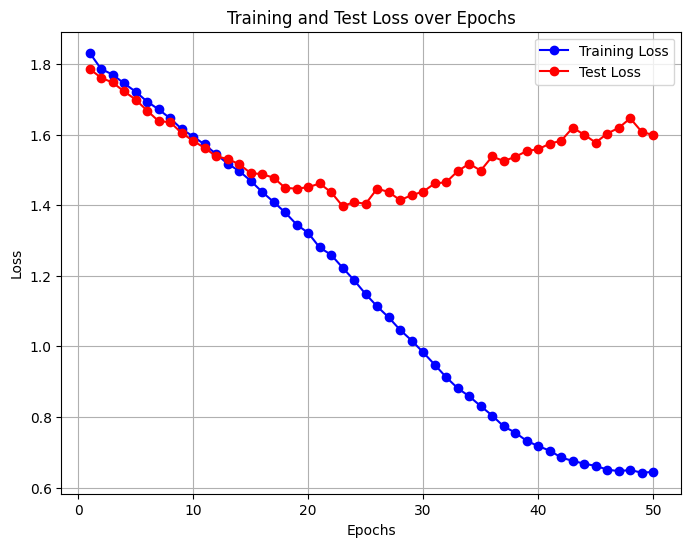

In [11]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 51)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Hence we take weights corresponding to epoch 23, for best generalisation

In [12]:
model = EmotionCNN()  # Assuming 7 emotions
model.load_state_dict(torch.load(f"/content/drive/MyDrive/fer2013/reproduced_cnn_23.pt"))

<All keys matched successfully>

In [15]:
model.to(device)

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [13]:
def extract_fc1_features(model, inputs):
    model.eval()
    with torch.no_grad():
        x = F.relu(model.conv1(inputs))
        x = model.pool(x)
        x = F.relu(model.conv2(x))
        x = model.pool(x)
        x = model.flatten(x)
        features = F.relu(model.fc1(x))
    return features  # shape (batch_size, 256)


In [16]:
all_features = []
all_labels = []

for inputs, labels in train_dl:
    feats = extract_fc1_features(model, inputs)
    all_features.append(feats.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

X_train = np.vstack(all_features)  # shape (N, 256)
y_train = np.hstack(all_labels)    # shape (N,)


In [17]:
all_features = []
all_labels = []

for inputs, labels in test_dl:  # Assume val_loader prepared
    feats = extract_fc1_features(model, inputs)
    all_features.append(feats.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

X_test = np.vstack(all_features)  # shape (N, 256)
y_test = np.hstack(all_labels)    # shape (N,)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Logistic Regression:", accuracy_score(y_test, lr.predict(X_test)))

Logistic Regression: 0.4265812203956534


In [20]:
# SVM
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
print("SVM:", accuracy_score(y_test, svm.predict(X_test)))

SVM: 0.44483142936751185


In [22]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
print("Random Forest:", accuracy_score(y_test, rf.predict(X_test)))

Random Forest: 0.47311228754527723


## Novelty code

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Custom transformation class
class FacePreprocessing:
    def __init__(self, size=(224, 224)):
        self.size = size
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.sift = cv2.SIFT_create()

    def detect_face(self, image):
        """Detect face using Viola-Jones (Haar cascade)."""
        image = np.array(image)
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)
        if len(faces) == 0:
            return None  # No face detected
        return faces[0]  # Return first detected face (x, y, w, h)

    def crop_face(self, image, face_coords):
        """Crop the face from the image."""
        x, y, w, h = face_coords
        return image[y:y+h, x:x+w]

    def resize_image(self, image):
        """Resize image to the standard size."""
        return cv2.resize(image, self.size)

    def normalize_image(self, image):
        """Normalize pixel values to [0,1] range."""
        return image / 255.0

    def gaussian_blur(self, image):
        """Apply Gaussian smoothing."""
        return cv2.GaussianBlur(image, (5, 5), 0)

    def sift_align_face(self, image):
        """Align face using SIFT keypoints matching."""
        if len(image.shape) == 2:
            gray = image
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        center_ref = (w // 2, h // 2)  # Assume nose is the center

        keypoints, descriptors = self.sift.detectAndCompute(gray, None)
        if len(keypoints) == 0:
            return image  # No keypoints detected, return original

        # Find the keypoint closest to the center (assume it's the nose region)
        center_kp = min(keypoints, key=lambda kp: (kp.pt[0] - center_ref[0])**2 + (kp.pt[1] - center_ref[1])**2)
        dx = center_ref[0] - center_kp.pt[0]
        dy = center_ref[1] - center_kp.pt[1]

        # Apply translation to center the keypoint
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        aligned = cv2.warpAffine(image, M, (w, h))
        return aligned

    def __call__(self, image):
        """Full preprocessing pipeline."""
        face_coords = self.detect_face(image)
        if face_coords is not None:
            image_np = np.array(image)
            face = self.crop_face(image_np, face_coords)
        else:
            face = np.array(image)  # Fallback if no face detected

        aligned_face = self.sift_align_face(face)
        resized_face = self.resize_image(aligned_face)
        blurred_face = self.gaussian_blur(resized_face)
        normalized_face = self.normalize_image(blurred_face)

        # Convert to PIL Image and return as Tensor
        return Image.fromarray((normalized_face * 255).astype(np.uint8))

# Define Data Augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(30),  # Randomly rotate images by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.RandomAffine(10, shear=10),  # Random affine transformations with a shear angle
])

# Apply custom transformations in the DataLoader
transform = transforms.Compose([
    FacePreprocessing(size=(48, 48)),  # Resize face images to 48x48 as in FER2013
    augmentation,
    transforms.ToTensor()
])

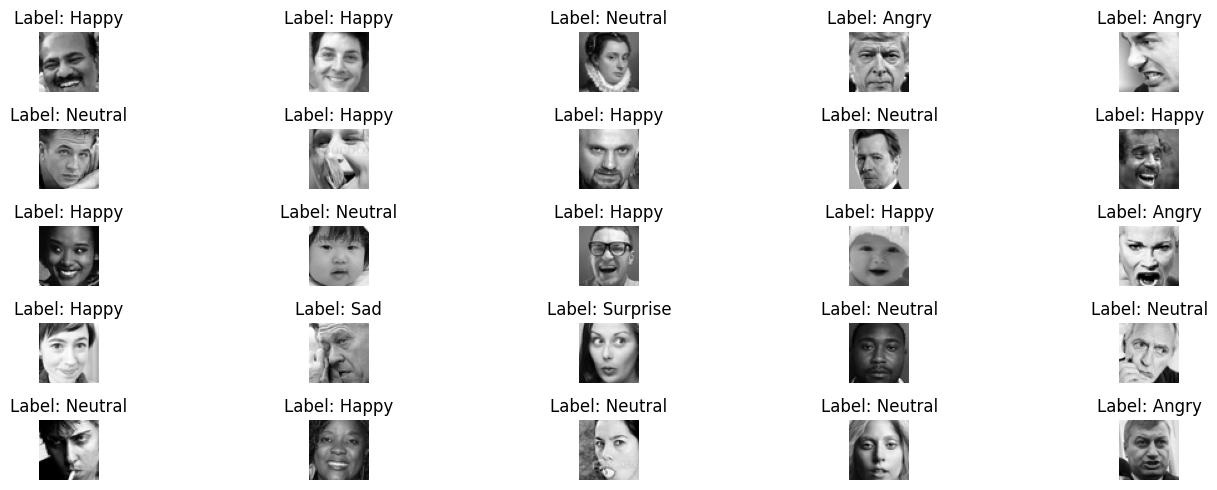

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
label_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}
# Assuming your dataset is already loaded into `train` (using the FER2013 dataset)
# You can change the dataset variable if you want to see examples from a different one
train = datasets.FER2013(root="/content/drive/MyDrive", split='train', transform=None)  # No transformation for visualization

# Define a function to display a few images and their labels
def show_images_and_labels(dataset, num_samples=25):
    fig, axes = plt.subplots(ncols = 5, nrows=5, figsize=(15, 5))
    indices = np.random.choice(len(dataset), num_samples, replace=False)  # Randomly select sample indices

    for i, idx in enumerate(indices):
        image, label = dataset[idx]  # Get image and label
        label_name = label_mapping[label]
        plt.subplot(5, 5, i + 1)  # Select the correct subplot
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label_name}')
        plt.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Show 5 random examples from the dataset
show_images_and_labels(train, num_samples=25)


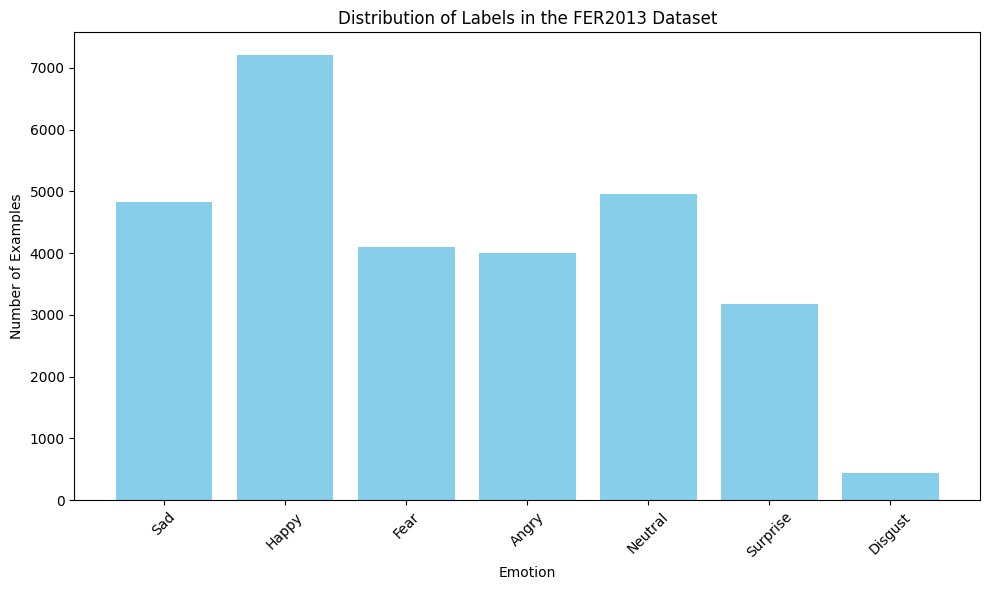

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader
from torchvision import datasets


# Emotion label mapping
# label_mapping = {
#     0: 'Angry',
#     1: 'Disgust',
#     2: 'Fear',
#     3: 'Happy',
#     4: 'Sad',
#     5: 'Surprise',
#     6: 'Neutral'
# }

# Load dataset
train = datasets.FER2013(root="/content/drive/MyDrive", split='train', transform=transforms.ToTensor())
train_dl = DataLoader(train, batch_size=32, shuffle=True)

# Initialize a counter for the labels
label_counts = Counter()

# Iterate through the dataset and count the occurrences of each label
for images, labels in train_dl:
    label_counts.update(labels.numpy())

# Convert counts into a list for plotting
labels_list = list(label_counts.keys())
counts_list = [label_counts[label] for label in labels_list]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar([label_mapping[label] for label in labels_list], counts_list, color='skyblue')
plt.title('Distribution of Labels in the FER2013 Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Examples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_train = np.array(list(label_counts.elements()))  # Flatten label counts to get the actual label list
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print("Class Weights (sklearn's Balanced):", dict(zip(np.unique(y_train), class_weights)))


Class Weights (sklearn's Balanced): {np.int64(0): np.float64(1.0266046844269623), np.int64(1): np.float64(9.406618610747051), np.int64(2): np.float64(1.0010460615781582), np.int64(3): np.float64(0.5684387684387684), np.int64(4): np.float64(0.8491274770777877), np.int64(5): np.float64(1.293372978330405), np.int64(6): np.float64(0.8260394187886635)}


In [4]:
train= datasets.FER2013(root="/content/drive/MyDrive", split='train',transform=transform)
test= datasets.FER2013(root="/content/drive/MyDrive", split='test', transform=transform)

In [5]:
from torch.utils.data import DataLoader
train_dl=DataLoader(train,batch_size=256,num_workers=2,shuffle=True,pin_memory=True)
test_dl=DataLoader(test,batch_size=256,shuffle=True,num_workers=2,pin_memory=True)

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  else:
    return data.to(device,non_blocking=True)

class DeviceDataloader():
  def __init__(self,device,dl):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch,self.device)

  def __len__(self):
    return len(self.dl)

device=get_default_device()
train_dl=DeviceDataloader(device,train_dl)
test_dl=DeviceDataloader(device,test_dl)
device

device(type='cuda')

## Modeling

In [6]:
import torch
from torch import nn
from torch.nn import Module, Conv2d, BatchNorm2d, MaxPool2d, ReLU, Dropout, Linear, Flatten, Softmax

class CNNWithResiduals(Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5), padding=2)
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=2)
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding=2)
        self.conv4 = Conv2d(in_channels=128, out_channels=256, kernel_size=(5, 5), padding=2)
        self.conv5 = Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1)

        # Batch normalization
        self.batchnorm1 = BatchNorm2d(num_features=32)
        self.batchnorm2 = BatchNorm2d(num_features=64)
        self.batchnorm3 = BatchNorm2d(num_features=128)
        self.batchnorm4 = BatchNorm2d(num_features=256)
        self.batchnorm5 = BatchNorm2d(num_features=512)

        # Shortcut (1x1 convolutions for dimension matching)
        self.shortcut1 = Conv2d(32, 64, kernel_size=1)
        self.shortcut2 = Conv2d(64, 128, kernel_size=1)
        self.shortcut3 = Conv2d(128, 256, kernel_size=1)
        self.shortcut4 = Conv2d(256, 512, kernel_size=1)

        # Other layers
        self.maxpool = MaxPool2d(kernel_size=(2, 2))
        self.relu = ReLU()
        self.dropout = Dropout(p=0.2)

        # Fully connected layers
        self.flatten = Flatten()
        self.fc1 = Linear(in_features=512, out_features=256)
        self.fc2 = Linear(in_features=256, out_features=128)
        self.fc3 = Linear(in_features=128, out_features=7)
        self.softmax = Softmax(dim=1)

    def forward(self, X):
        # block 1
        X = self.conv1(X)
        X = self.batchnorm1(X)
        X = self.relu(X)
        X = self.maxpool(X)
        residual = X  # Save input for residual connection

        # block 2
        X2 = self.conv2(X)
        X2 = self.batchnorm2(X2)
        X2 = self.relu(X2)
        residual= self.shortcut1(residual)
        X2 = residual + X2  # Residual connection
        X2 = self.maxpool(X2)
        residual = X2  # Update residual

        # block 3
        X3 = self.conv3(X2)
        X3 = self.batchnorm3(X3)
        X3 = self.relu(X3)
        residual= self.shortcut2(residual)
        X3 = residual + X3
        X3 = self.maxpool(X3)
        residual = X3  # Update residual

        # block 4
        X4 = self.conv4(X3)
        X4 = self.batchnorm4(X4)
        X4 = self.relu(X4)
        residual= self.shortcut3(residual)
        X4 = residual + X4
        X4 = self.maxpool(X4)
        residual = X4  # Update residual
        X4 = self.dropout(X4)

        # block 5
        X5 = self.conv5(X4)
        X5 = self.batchnorm5(X5)
        X5 = self.relu(X5)
        residual= self.shortcut4(residual)
        X5 = residual + X5
        X5 = self.maxpool(X5)
        X5 = self.dropout(X5)

        # Fully connected layers
        X = self.flatten(X5)
        X = self.fc1(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.fc2(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.fc3(X)
        return X


In [ ]:
model = CNNWithResiduals()  # Assuming 7 emotions
model.load_state_dict(torch.load('/content/drive/MyDrive/fer2013/novelty_cnn_20.pt'))
model.to(device)
opt=torch.optim.Adam(model.parameters(),lr=1e-3)
from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights,dtype=torch.float32).to(device))
train_epoch_losses=[1.9335622629233167,1.9115852623914196,1.8636445925299046,1.7956689680572104,1.7502789391880542,1.7093526968913795,1.6736734989470086,1.6281742553795333,1.5837159082952854,1.5569634437561035,1.5041446453702134,1.485391425875436,1.4328356168966379,1.4042474326834213,1.3800921904302277,1.3364188787156501,1.3018387065524548,1.2706998470610222,1.2562480415918131,1.2529771380719885]
test_epoch_losses=[1.9151666616571361,1.8820499633920604,1.7923640752660817,1.766135655600449, 1.7889758430678269,2.0630312253688943,1.6917066738523285,1.6365406677640717,1.7491553158595645,1.5604772115575856,1.5589870378888886,1.6311185113314925,1.492020187706783,1.4952086251357506,1.4467110284443558,1.4339608406198436,1.3654604965242847,1.3603459432207305,1.4097865367757862,1.385476842008788]

In [ ]:
scheduler = OneCycleLR(opt, max_lr=1e-3, epochs=50, steps_per_epoch=len(train_dl))
for i in range(20):
  scheduler.step()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [ ]:
for epoch in range(30):  # Set the number of epochs
    model.train()
    train_epoch_loss = 0
    test_epoch_loss=0
    for images, label in train_dl:
        # Forward pass
        outputs = model(images)
        loss=criterion(outputs, label)
        train_epoch_loss += loss.item()

        # Backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
    train_epoch_losses.append(train_epoch_loss/len(train_dl))
    print(f"Epoch {epoch+1}, Train Loss: {train_epoch_loss/len(train_dl)}")

    for images, label in test_dl:
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, label)
            test_epoch_loss += loss.item()
    test_epoch_losses.append(test_epoch_loss/len(test_dl))
    print(f"Test Loss: {test_epoch_loss/len(test_dl)}")
    torch.save(model.state_dict(),f"/content/drive/MyDrive/fer2013/novelty_cnn_{epoch+21}.pt")

Epoch 1, Train Loss: 1.2592090779701166
Test Loss: 1.397979551348193
Epoch 2, Train Loss: 1.247755706837747
Test Loss: 1.3887471536110187
Epoch 3, Train Loss: 1.253032800370613
Test Loss: 1.3618370294570923
Epoch 4, Train Loss: 1.2443513743645322
Test Loss: 1.369743355389299
Epoch 5, Train Loss: 1.2599436313705106
Test Loss: 1.3815296025111758
Epoch 6, Train Loss: 1.2665169745419933
Test Loss: 1.5360511048086758
Epoch 7, Train Loss: 1.2735325604413463
Test Loss: 1.5148649092378288
Epoch 8, Train Loss: 1.28701933084336
Test Loss: 1.468674429531755
Epoch 9, Train Loss: 1.2984187550249353
Test Loss: 1.4257306764865745
Epoch 10, Train Loss: 1.3195453291445707
Test Loss: 1.4499426422447994
Epoch 11, Train Loss: 1.323581551028564
Test Loss: 1.4929306671537201
Epoch 12, Train Loss: 1.338902142195575
Test Loss: 1.4228664102225468
Epoch 13, Train Loss: 1.320487019235054
Test Loss: 1.498628986292872
Epoch 14, Train Loss: 1.3016992580574172
Test Loss: 1.430562255711391
Epoch 15, Train Loss: 1.289

In [ ]:
torch.save(model.state_dict(),f"/content/drive/MyDrive/fer2013/novelty_cnn_50.pt")
print(train_epoch_losses)
print(test_epoch_losses)

[1.9335622629233167, 1.9115852623914196, 1.8636445925299046, 1.7956689680572104, 1.7502789391880542, 1.7093526968913795, 1.6736734989470086, 1.6281742553795333, 1.5837159082952854, 1.5569634437561035, 1.5041446453702134, 1.485391425875436, 1.4328356168966379, 1.4042474326834213, 1.3800921904302277, 1.3364188787156501, 1.3018387065524548, 1.2706998470610222, 1.2562480415918131, 1.2529771380719885, 1.2592090779701166, 1.247755706837747, 1.253032800370613, 1.2443513743645322, 1.2599436313705106, 1.2665169745419933, 1.2735325604413463, 1.28701933084336, 1.2984187550249353, 1.3195453291445707, 1.323581551028564, 1.338902142195575, 1.320487019235054, 1.3016992580574172, 1.2898381347149874, 1.291619835701664, 1.2549421934954887, 1.2811664954750939, 1.2618670263121614, 1.2361428611046446, 1.2220516268130952, 1.2129327438573922, 1.1977734676504557, 1.1763511611297068, 1.1787817156420344, 1.1419150697446503, 1.160538975116426, 1.11813136539628, 1.1212427278535555, 1.0916133865845943]
[1.91516666

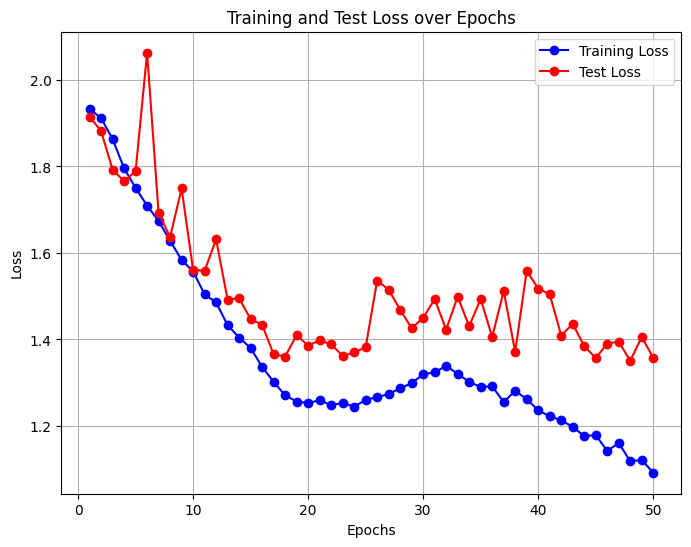

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 51)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


As can be seen from the above graph for best generalisation we take weights corresponding to epoch 18

In [9]:
model = CNNWithResiduals()  # Assuming 7 emotions
model.load_state_dict(torch.load('/content/drive/MyDrive/fer2013/novelty_cnn_18.pt'))
model.to(device)

CNNWithResiduals(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (shortcut2): Conv2d(64, 128, kernel_size=(1

In [10]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# First, get all predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dl:
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)  # Get the class with highest probability
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now compute the metrics
accuracy = accuracy_score(all_labels, all_preds)
f1_macro = f1_score(all_labels, all_preds, average='macro')  # Average F1 over all classes
f1_weighted = f1_score(all_labels, all_preds, average='weighted')  # Weighted average F1

# Generate full classification report
report = classification_report(all_labels, all_preds, target_names=[
    'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'
])

print("Accuracy:", accuracy)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Weighted):", f1_weighted)
print("\nClassification Report:\n", report)


Accuracy: 0.5345500139314572
F1 Score (Macro): 0.488631650079423
F1 Score (Weighted): 0.5280070253207869

Classification Report:
               precision    recall  f1-score   support

       Angry       0.45      0.43      0.44       958
     Disgust       0.25      0.56      0.34       111
        Fear       0.41      0.23      0.29      1024
       Happy       0.74      0.75      0.75      1774
         Sad       0.41      0.43      0.42      1247
    Surprise       0.65      0.71      0.68       831
     Neutral       0.47      0.54      0.50      1233

    accuracy                           0.53      7178
   macro avg       0.48      0.52      0.49      7178
weighted avg       0.53      0.53      0.53      7178



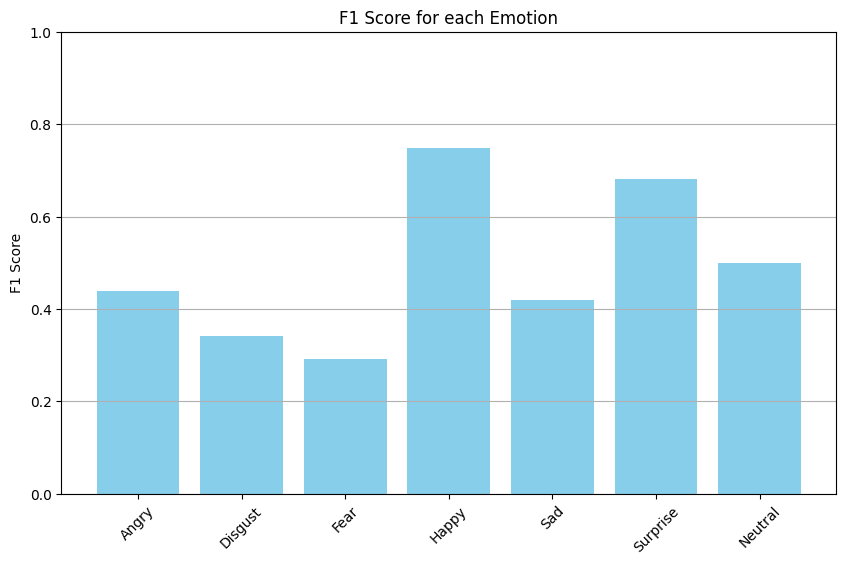

In [11]:
class_f1_scores = f1_score(all_labels, all_preds, average=None)
# Class names (your mapping)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

x = np.arange(len(class_names))  # label locations

plt.figure(figsize=(10,6))
plt.bar(x, class_f1_scores, color='skyblue')
plt.xticks(x, class_names, rotation=45)
plt.ylim(0, 1)  # F1 scores are between 0 and 1
plt.ylabel('F1 Score')
plt.title('F1 Score for each Emotion')
plt.grid(axis='y')
plt.show()

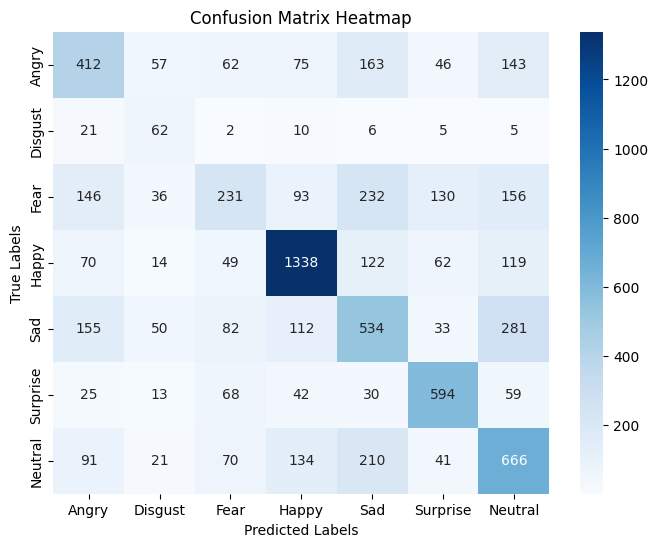

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

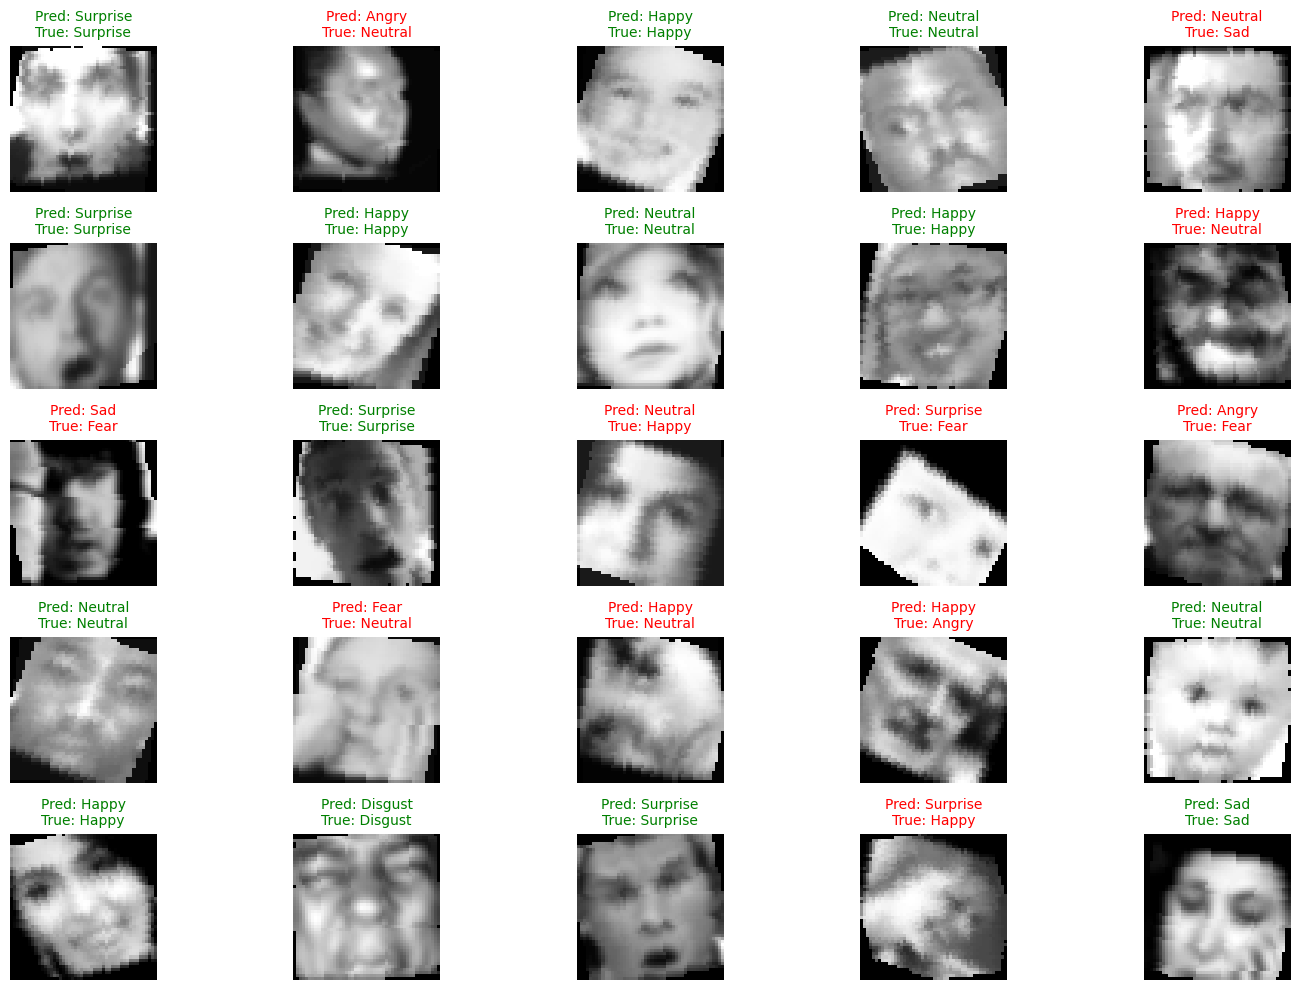

In [13]:
# Get one batch from test_dl
images, labels = next(iter(test_dl))

# Move to CPU if necessary
# images = images.cpu()
# labels = labels.cpu()

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
# Plot some images
num_images = 25  # Number of images you want to display
plt.figure(figsize=(15, 10))

for idx in range(num_images):
    plt.subplot(5, 5, idx+1)
    img = images[idx].permute(1, 2, 0).cpu().numpy()  # CxHxW -> HxWxC
    img = img.squeeze()  # Remove channel dim if grayscale

    plt.imshow(img, cmap='gray')
    pred_label = class_names[preds[idx]]
    true_label = class_names[labels[idx]]

    # Title color
    color = 'green' if preds[idx] == labels[idx] else 'red'

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
